Baseline_TF
https://www.kaggle.com/code/ivaneleskin/baseline-tf

In [1]:
import os
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from tqdm import tqdm
import json
import gc
from sklearn.model_selection import train_test_split
# import missingno as msno

from pathlib import Path

2023-03-01 12:03:37.420214: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-01 12:03:37.568709: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-01 12:03:38.032590: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/victor/miniconda3/envs/tf/lib/:/home/victor/miniconda3/envs/tf/lib/:/home/victor/miniconda3/envs/tf/lib/:/home/victor/miniconda3/envs/tf/lib/
2023-03-01 12:03:38.032672: W tensorflow/stream_executor/platfo

In [2]:
DATA_ROOT = Path('..')
DF_TRAIN = DATA_ROOT / 'train.csv'
train = pd.read_csv(DF_TRAIN)

print("train.shape = {} rows, {} cols".format(*train.shape))
train.info()
train.head()


train.shape = 94477 rows, 4 cols
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94477 entries, 0 to 94476
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   path            94477 non-null  object
 1   participant_id  94477 non-null  int64 
 2   sequence_id     94477 non-null  int64 
 3   sign            94477 non-null  object
dtypes: int64(2), object(2)
memory usage: 2.9+ MB


,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie


In [3]:
class CFG:
    data_path = "../"
    quick_experiment = False
    is_training = True
    use_aggregation_dataset = True
    num_classes = 250
    rows_per_frame = 543 

def load_relevant_data_subset_with_imputation(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    data.replace(np.nan, 0, inplace=True)
    n_frames = int(len(data) / CFG.rows_per_frame)
    data = data.values.reshape(n_frames, CFG.rows_per_frame, len(data_columns))
    return data.astype(np.float32)

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / CFG.rows_per_frame)
    data = data.values.reshape(n_frames, CFG.rows_per_frame, len(data_columns))
    return data.astype(np.float32)

def read_dict(file_path):
    path = os.path.expanduser(file_path)
    with open(path, "r") as f:
        dic = json.load(f)
    return dic

In [4]:
train = pd.read_csv(f"{CFG.data_path}train.csv")
label_index = read_dict(f"{CFG.data_path}sign_to_prediction_index_map.json")
index_label = {label_index[key]: key for key in label_index}
train["label"] = train["sign"].map(lambda sign: label_index[sign])

In [5]:
MAX_FRAMES = 5
X_npy_fname = f'X_3d-avg-{MAX_FRAMES}_frames.npy'
y_npy_fname = f'y.npy'


if CFG.is_training:
    try:
        X = np.load(X_npy_fname)
        y = np.load(y_npy_fname)
    except:
        print('True')
        X = np.zeros((len(train), 543, 3))
        y = np.zeros((len(train),))
        num_frames = np.zeros(len(train))
        for i in tqdm(range(len(train))):
            path = f"{CFG.data_path}{train.iloc[i].path}"
            data = load_relevant_data_subset_with_imputation(path)
            ## Mean Aggregation
            data_resize = tf.image.resize(
                data,
                (MAX_FRAMES, 543),
                method='nearest',
            )
            X[i] = np.mean(data_resize, axis=0)
            y[i] = train.iloc[i].label
            num_frames[i] = data.shape[0]
            if CFG.quick_experiment and i == 4999:
                break
        ## Save number of frames of each training sample for data analysis
        train["num_frames"] = num_frames
        print(train["num_frames"].describe())
        train.to_csv("train.csv", index=False)
        np.save(X_npy_fname, X)
        np.save(y_npy_fname, y)

    print(X.shape, y.shape)

(94477, 543, 3) (94477,)


In [6]:
X.shape

(94477, 543, 3)

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=27, stratify=y)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(75581, 543, 3) (75581,) (18896, 543, 3) (18896,)


|part|start|end|
|----|--|---|
|face| 0| 467|
|left_hand| 468| 488|
|pose| 489| 521|
|right_hand| 522| 542|

In [8]:
# inputs = tf.keras.Input((MAX_FRAMES, 543, 3), dtype=tf.float32)
# h1 = tf.keras.layers.Dense(128, activation="relu")(inputs)
# h1 = tf.keras.layers.Dense(128, activation="relu")(h1)
# h1 = tf.keras.layers.Dropout(0.2)(h1)
# h2 = tf.keras.layers.Dense(64, activation="relu")(h1)
# h2 = tf.keras.layers.Dense(64, activation="relu")(h2)
# h3 = tf.keras.layers.Dropout(0.2)(h2)

# concat = tf.keras.layers.Concatenate()([inputs, h3])
# vector = tf.keras.layers.Dense(64, activation="relu")(concat)
# vector = tf.keras.layers.Dense(64, activation="relu")(vector)
# vector = tf.keras.layers.Dropout(0.2)(vector)
# vector = tf.keras.layers.Flatten()(vector)
# output = tf.keras.layers.Dense(250, activation="softmax")(vector)


# model = tf.keras.Model(inputs=inputs, outputs=output)
# model.compile(
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#     optimizer='adam',
#     metrics=[
#         'accuracy',
#         tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top-05-acc'),
#         tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10, name='top-10-acc'),
#     ]
# )

In [9]:
# tf.keras.layers.Lambda(lambda x: x[:, 0:  468, :]) #face
# tf.keras.layers.Lambda(lambda x: x[:, 468:489, :]) #left_hand
# tf.keras.layers.Lambda(lambda x: x[:, 489:522, :]) #pose
# tf.keras.layers.Lambda(lambda x: x[:, 522:542, :]) #right_hand

In [10]:
# N_FACE_PTS = 468
# N_HAND_PTS = 21
# N_POSE_PTS = 20


# input_left = tf.keras.layers.Input(shape=(N_HAND_PTS,))
# input_right = tf.keras.layers.Input(shape=(N_HAND_PTS,))
# input_face = tf.keras.layers.Input(shape=(N_FACE_PTS,))
# input_pose = tf.keras.layers.Input(shape=(N_POSE_PTS,))


# head_avg = tf.keras.layers.Lambda(
#     lambda x: tf.reduce_mean(x, axis=1, keepdims=True))(input_face)

# # Get just the left hand + avg head
# left_head_avg = tf.keras.layers.Concatenate()([input_left, head_avg])

# # Get just the right hand + avg head
# right_head_avg = tf.keras.layers.Concatenate()([input_right, head_avg])



# x1 = tf.keras.layers.Dense(8, activation='relu')(input1)
# input2 = tf.keras.layers.Input(shape=(32,))
# x2 = tf.keras.layers.Dense(8, activation='relu')(input2)
# avg = tf.keras.layers.Average()([x1, x2])
# out = tf.keras.layers.Dense(4)(avg)
# model = tf.keras.models.Model(inputs=[input1, input2], outputs=out)

In [11]:
# inputs = tf.keras.Input((543, 3), dtype=tf.float32)
# h1 = tf.keras.layers.Dense(128, activation="relu")(inputs)
# h2 = tf.keras.layers.Dense(64, activation="relu")(h1)
# h3 = tf.keras.layers.Dense(64, activation="relu")(h2)
# 
# concat = tf.keras.layers.Concatenate()([inputs, h3])
# vector = tf.keras.layers.Dense(64, activation="relu")(concat)
# vector = tf.keras.layers.Dense(32, activation="relu")(vector)
# vector = tf.keras.layers.Dense(32, activation="relu")(vector)
# vector = tf.keras.layers.Flatten()(vector)
# output = tf.keras.layers.Dense(250, activation="softmax")(vector)

# model = tf.keras.Model(inputs=inputs, outputs=output)
# model.compile(
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
#     metrics=[
#         "accuracy",
#         tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name="top-5-accuracy"),
#         tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10),
#     ]
# )

In [12]:
# model = tf.keras.Sequential([
# #     tf.keras.layers.ConvLSTM1D(128, kernel_size=2, return_sequences=True, input_shape=[None, 543, 3]),
# #     tf.keras.layers.ConvLSTM1D(128, kernel_size=2,),
#     tf.keras.layers.GRU(256, return_sequences=True, input_shape=(None, 3)),
#     tf.keras.layers.GRU(256),
#     tf.keras.layers.Dense(256, activation="relu"),
#     tf.keras.layers.Dropout(0.4),
#     tf.keras.layers.Dense(128, activation="relu"),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(128, activation="relu"),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(64, activation="relu"),
#     tf.keras.layers.Dense(64, activation="relu"),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(250, activation="softmax"),
# ])

# model.compile(
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
#     optimizer='adam',
#     metrics=[
#         "accuracy",
#         tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name="top-05-acc"),
#         tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10, name="top-10-acc"),
#     ]
# )

# model.summary()

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.GRU(128, return_sequences=True, input_shape=(None, 3)),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(250, activation='softmax'),
])

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
    metrics=[
        "accuracy",
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name="top-05-acc"),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10, name="top-10-acc"),
    ]
)

model.summary()

2023-03-01 12:03:39.534582: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-01 12:03:39.541346: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-01 12:03:39.541610: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-01 12:03:39.542369: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, None, 128)         51072     
                                                                 
 gru_1 (GRU)                 (None, 128)               99072     
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

In [14]:
if True:
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint("model.h5"),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=6,
            restore_best_weights=True,
        ),
    ]
    history = model.fit(
        X_train,
        y_train,
        epochs=500,
        validation_data=(X_val, y_val),
        batch_size=128,
        callbacks=callbacks,
    )
else:
    model = tf.keras.models.load_model("../model.h5")

Epoch 1/500


2023-03-01 12:03:43.573708: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


  1/591 [..............................] - ETA: 32:40 - loss: 5.5215 - accuracy: 0.0156 - top-05-acc: 0.0156 - top-10-acc: 0.0391

2023-03-01 12:03:44.247620: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


591/591 [==============================] - 46s 73ms/step - loss: 5.4563 - accuracy: 0.0054 - top-05-acc: 0.0261 - top-10-acc: 0.0524 - val_loss: 5.3873 - val_accuracy: 0.0075 - val_top-05-acc: 0.0354 - val_top-10-acc: 0.0683
Epoch 2/500
591/591 [==============================] - 43s 73ms/step - loss: 5.3127 - accuracy: 0.0095 - top-05-acc: 0.0467 - top-10-acc: 0.0875 - val_loss: 5.1786 - val_accuracy: 0.0171 - val_top-05-acc: 0.0730 - val_top-10-acc: 0.1303
Epoch 3/500
591/591 [==============================] - 43s 72ms/step - loss: 5.0342 - accuracy: 0.0215 - top-05-acc: 0.0918 - top-10-acc: 0.1642 - val_loss: 4.8640 - val_accuracy: 0.0367 - val_top-05-acc: 0.1307 - val_top-10-acc: 0.2201
Epoch 4/500
591/591 [==============================] - 42s 70ms/step - loss: 4.8461 - accuracy: 0.0336 - top-05-acc: 0.1305 - top-10-acc: 0.2210 - val_loss: 4.7602 - val_accuracy: 0.0469 - val_top-05-acc: 0.1635 - val_top-10-acc: 0.2600
Epoch 5/500
591/591 [==============================] - 42s 72ms/

591/591 [==============================] - 43s 73ms/step - loss: 3.1016 - accuracy: 0.2647 - top-05-acc: 0.5732 - top-10-acc: 0.6953 - val_loss: 3.0052 - val_accuracy: 0.2843 - val_top-05-acc: 0.5926 - val_top-10-acc: 0.7075
Epoch 36/500
591/591 [==============================] - 43s 73ms/step - loss: 3.0830 - accuracy: 0.2652 - top-05-acc: 0.5766 - top-10-acc: 0.6987 - val_loss: 3.0687 - val_accuracy: 0.2779 - val_top-05-acc: 0.5785 - val_top-10-acc: 0.6958
Epoch 37/500
591/591 [==============================] - 43s 72ms/step - loss: 3.0629 - accuracy: 0.2706 - top-05-acc: 0.5820 - top-10-acc: 0.7013 - val_loss: 2.9716 - val_accuracy: 0.3003 - val_top-05-acc: 0.5976 - val_top-10-acc: 0.7077
Epoch 38/500
591/591 [==============================] - 43s 72ms/step - loss: 3.0470 - accuracy: 0.2751 - top-05-acc: 0.5848 - top-10-acc: 0.7041 - val_loss: 2.9274 - val_accuracy: 0.3108 - val_top-05-acc: 0.6116 - val_top-10-acc: 0.7221
Epoch 39/500
591/591 [==============================] - 42s 7

591/591 [==============================] - 42s 72ms/step - loss: 2.7397 - accuracy: 0.3404 - top-05-acc: 0.6475 - top-10-acc: 0.7478 - val_loss: 2.7134 - val_accuracy: 0.3564 - val_top-05-acc: 0.6530 - val_top-10-acc: 0.7503
Epoch 70/500
591/591 [==============================] - 42s 72ms/step - loss: 2.7347 - accuracy: 0.3425 - top-05-acc: 0.6485 - top-10-acc: 0.7497 - val_loss: 2.6528 - val_accuracy: 0.3725 - val_top-05-acc: 0.6672 - val_top-10-acc: 0.7598
Epoch 71/500
591/591 [==============================] - 42s 72ms/step - loss: 2.7201 - accuracy: 0.3457 - top-05-acc: 0.6527 - top-10-acc: 0.7535 - val_loss: 2.6834 - val_accuracy: 0.3597 - val_top-05-acc: 0.6560 - val_top-10-acc: 0.7530
Epoch 72/500
591/591 [==============================] - 43s 73ms/step - loss: 2.7162 - accuracy: 0.3479 - top-05-acc: 0.6533 - top-10-acc: 0.7535 - val_loss: 2.7368 - val_accuracy: 0.3548 - val_top-05-acc: 0.6518 - val_top-10-acc: 0.7470
Epoch 73/500
591/591 [==============================] - 43s 7

591/591 [==============================] - 42s 72ms/step - loss: 2.6001 - accuracy: 0.3750 - top-05-acc: 0.6743 - top-10-acc: 0.7645 - val_loss: 2.6285 - val_accuracy: 0.3806 - val_top-05-acc: 0.6701 - val_top-10-acc: 0.7602
Epoch 104/500
591/591 [==============================] - 42s 72ms/step - loss: 2.5999 - accuracy: 0.3744 - top-05-acc: 0.6745 - top-10-acc: 0.7650 - val_loss: 2.7343 - val_accuracy: 0.3640 - val_top-05-acc: 0.6502 - val_top-10-acc: 0.7431
Epoch 105/500
591/591 [==============================] - 42s 72ms/step - loss: 2.5943 - accuracy: 0.3750 - top-05-acc: 0.6750 - top-10-acc: 0.7673 - val_loss: 2.6544 - val_accuracy: 0.3761 - val_top-05-acc: 0.6660 - val_top-10-acc: 0.7600
Epoch 106/500
591/591 [==============================] - 42s 72ms/step - loss: 2.6011 - accuracy: 0.3759 - top-05-acc: 0.6732 - top-10-acc: 0.7664 - val_loss: 2.6204 - val_accuracy: 0.3832 - val_top-05-acc: 0.6718 - val_top-10-acc: 0.7601
Epoch 107/500
591/591 [==============================] - 4

In [15]:
import matplotlib.pyplot as plt
import numpy as np

print(history.history.keys())

dict_keys(['loss', 'accuracy', 'top-05-acc', 'top-10-acc', 'val_loss', 'val_accuracy', 'val_top-05-acc', 'val_top-10-acc'])


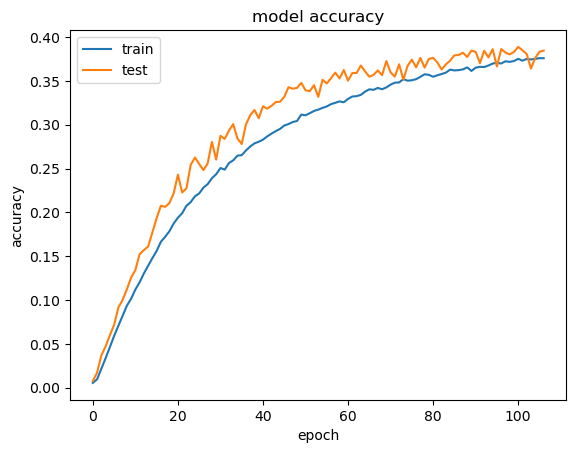

In [16]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

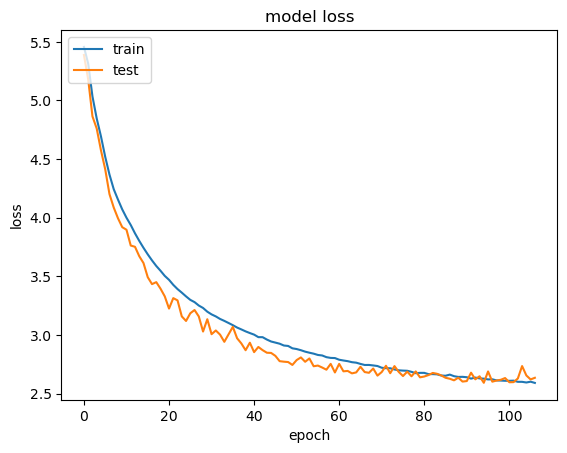

In [17]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
def get_model():
    return model

In [19]:
get_model().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, None, 128)         51072     
                                                                 
 gru_1 (GRU)                 (None, 128)               99072     
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

In [20]:
inputs = tf.keras.Input((543, 3), dtype=tf.float32, name="inputs")
x = tf.where(tf.math.is_nan(inputs), tf.zeros_like(inputs), inputs)
x = tf.reduce_mean(x, axis=0, keepdims=True)

# for i in range(1, len(model.layers)):
x = model.layers[0](x)
x = model.layers[1](x)
x = model.layers[2](x)

In [21]:
def get_inference_model(model):
    inputs = tf.keras.Input((543, 3), dtype=tf.float32, name="inputs")
    x = tf.where(tf.math.is_nan(inputs), tf.zeros_like(inputs), inputs)
    x = tf.reduce_mean(x, axis=0, keepdims=True)
    
    for i in range(0, len(model.layers)):
        x = model.layers[i](x)
    output = tf.keras.layers.Activation(activation="linear", name="outputs")(x)
    inference_model = tf.keras.Model(inputs=inputs, outputs=output) 
    inference_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
    
    return inference_model

In [22]:
inference_model = get_inference_model(model)
inference_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 543, 3)]     0           []                               
                                                                                                  
 tf.math.is_nan_1 (TFOpLambda)  (None, 543, 3)       0           ['inputs[0][0]']                 
                                                                                                  
 tf.zeros_like_1 (TFOpLambda)   (None, 543, 3)       0           ['inputs[0][0]']                 
                                                                                                  
 tf.where_1 (TFOpLambda)        (None, 543, 3)       0           ['tf.math.is_nan_1[0][0]',       
                                                                  'tf.zeros_like_1[0][0]',    

In [23]:
converter = tf.lite.TFLiteConverter.from_keras_model(inference_model)
tflite_model = converter.convert()
model_path = "model.tflite"
# Save the model.
with open(model_path, 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpi02ldz7a/assets


INFO:tensorflow:Assets written to: /tmp/tmpi02ldz7a/assets
2023-03-01 13:19:30.049813: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-03-01 13:19:30.049860: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-03-01 13:19:30.050443: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpi02ldz7a
2023-03-01 13:19:30.061395: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-03-01 13:19:30.061422: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpi02ldz7a
2023-03-01 13:19:30.094713: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2023-03-01 13:19:30.103574: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-03-01 13:19:30.182077: I tensorflow/cc/saved_model/loader.cc:213] Running initializatio

In [24]:
import tflite_runtime.interpreter as tflite
interpreter = tflite.Interpreter(model_path)
found_signatures = list(interpreter.get_signature_list().keys())
prediction_fn = interpreter.get_signature_runner("serving_default")
corr = 0
wrong = []
for i in tqdm(range(100)):
    frames = load_relevant_data_subset(f'../{train.iloc[i].path}')
    output = prediction_fn(inputs=frames)
    sign = np.argmax(output["outputs"])
    if index_label[sign] == train.iloc[i].sign:
        corr += 1
    else:
        wrong.append((index_label[sign], train.iloc[i].sign, train.iloc[i].path))

    #     print(f"Predicted label: {index_label[sign]}, Actual Label: {train.iloc[i].sign}")


    total = i

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 31.51it/s]


In [25]:
r = f'''
{total=}
{corr=}\t Percent: {corr/total:%}
'''
print(r)


total=99
corr=52	 Percent: 52.525253%



In [26]:
wrongs = pd.DataFrame(data=wrong, columns=['pred','true','path'])
wrongs.groupby('pred').count().reset_index().sort_values('true')

,pred,true,path
0,after,1,1
35,wolf,1,1
33,wake,1,1
31,uncle,1,1
30,thirsty,1,1
29,there,1,1
28,store,1,1
27,red,1,1
26,pretty,1,1
25,pig,1,1


In [27]:
model = tf.keras.Sequential([
    tf.keras.layers.GRU(256, return_sequences=True, input_shape=(None, 3)),
    tf.keras.layers.GRU(256),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(250, activation='softmax'),
])

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
    metrics=[
        "accuracy",
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name="top-05-acc"),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10, name="top-10-acc"),
    ]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, None, 256)         200448    
                                                                 
 gru_3 (GRU)                 (None, 256)               394752    
                                                                 
 dense_6 (Dense)             (None, 256)               65792     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dense_8 (Dense)             (None, 128)               16512     
                                                                 
 dropout_4 (Dropout)         (None, 128)              

In [28]:
# if True:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("_model.h5"),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=6,
        restore_best_weights=True,
    ),
]
history = model.fit(
    X_train,
    y_train,
    epochs=500,
    validation_data=(X_val, y_val),
    batch_size=128,
    callbacks=callbacks,
)

Epoch 1/500
591/591 [==============================] - 48s 78ms/step - loss: 5.4677 - accuracy: 0.0052 - top-05-acc: 0.0260 - top-10-acc: 0.0508 - val_loss: 5.3819 - val_accuracy: 0.0072 - val_top-05-acc: 0.0342 - val_top-10-acc: 0.0635
Epoch 2/500
591/591 [==============================] - 45s 77ms/step - loss: 5.2267 - accuracy: 0.0139 - top-05-acc: 0.0626 - top-10-acc: 0.1129 - val_loss: 5.0336 - val_accuracy: 0.0186 - val_top-05-acc: 0.0862 - val_top-10-acc: 0.1572
Epoch 3/500
591/591 [==============================] - 45s 76ms/step - loss: 4.9447 - accuracy: 0.0318 - top-05-acc: 0.1193 - top-10-acc: 0.1979 - val_loss: 4.8680 - val_accuracy: 0.0368 - val_top-05-acc: 0.1409 - val_top-10-acc: 0.2217
Epoch 4/500
591/591 [==============================] - 44s 75ms/step - loss: 4.7904 - accuracy: 0.0457 - top-05-acc: 0.1636 - top-10-acc: 0.2518 - val_loss: 4.6605 - val_accuracy: 0.0605 - val_top-05-acc: 0.1983 - val_top-10-acc: 0.2915
Epoch 5/500
591/591 [==============================]

591/591 [==============================] - 45s 77ms/step - loss: 2.6814 - accuracy: 0.3534 - top-05-acc: 0.6575 - top-10-acc: 0.7568 - val_loss: 2.7102 - val_accuracy: 0.3629 - val_top-05-acc: 0.6479 - val_top-10-acc: 0.7428
Epoch 36/500
591/591 [==============================] - 45s 75ms/step - loss: 2.6561 - accuracy: 0.3583 - top-05-acc: 0.6613 - top-10-acc: 0.7611 - val_loss: 2.6525 - val_accuracy: 0.3697 - val_top-05-acc: 0.6635 - val_top-10-acc: 0.7578
Epoch 37/500
591/591 [==============================] - 45s 76ms/step - loss: 2.6364 - accuracy: 0.3628 - top-05-acc: 0.6649 - top-10-acc: 0.7611 - val_loss: 2.6501 - val_accuracy: 0.3753 - val_top-05-acc: 0.6622 - val_top-10-acc: 0.7532
Epoch 38/500
591/591 [==============================] - 45s 76ms/step - loss: 2.6134 - accuracy: 0.3678 - top-05-acc: 0.6696 - top-10-acc: 0.7658 - val_loss: 2.6417 - val_accuracy: 0.3765 - val_top-05-acc: 0.6670 - val_top-10-acc: 0.7587
Epoch 39/500
591/591 [==============================] - 45s 7

591/591 [==============================] - 45s 77ms/step - loss: 2.2854 - accuracy: 0.4431 - top-05-acc: 0.7253 - top-10-acc: 0.8018 - val_loss: 2.5791 - val_accuracy: 0.4121 - val_top-05-acc: 0.6829 - val_top-10-acc: 0.7659


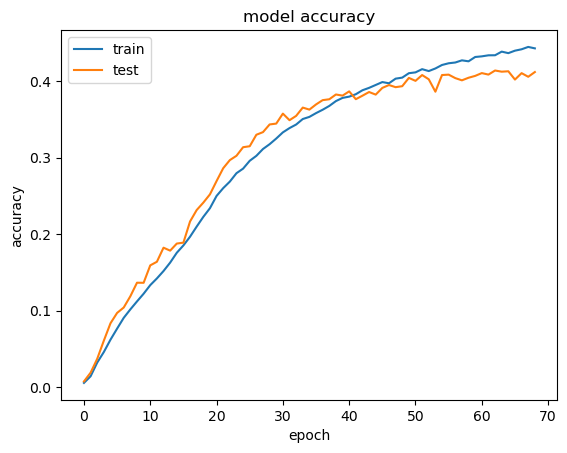

In [29]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

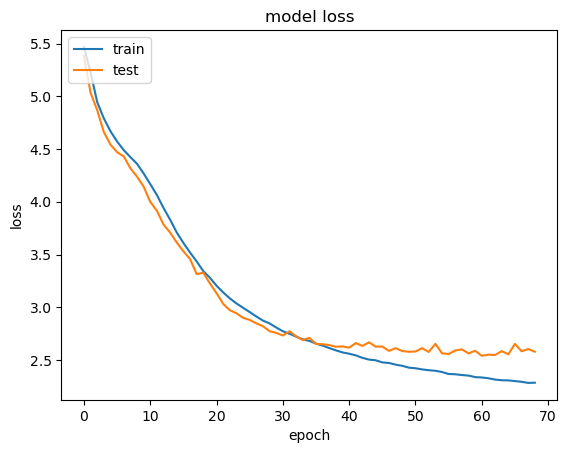

In [30]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()